# Práctica Final: Clasificación con Scikit-learn y MLflow

En esta práctica, utilizarás un conjunto de datos de Scikit-learn (podeís usar el mismo que en el notebook de Intro MLFlow) para entrenar un modelo de clasificación.

Pasos a seguir: 

    Exploración de Datos: Analiza el conjunto de datos proporcionado para comprender su estructura y contenido.

    Preprocesamiento de Texto: Realiza tareas de preprocesamiento de texto, como tokenización y vectorización, para preparar los datos para el modelado.

    Entrenamiento del Modelo: Utiliza algoritmos de clasificación de Scikit-learn para entrenar un modelo con los datos preprocesados.

    Evaluación del Modelo: Evalúa el rendimiento del modelo utilizando métricas de evaluación estándar como precisión y recall.

    Registro de Métricas con MLflow: Utiliza MLflow para registrar métricas y hiperparámetros durante el entrenamiento, facilitando la gestión y comparación de experimentos.


Nota: Dado que no voy a poder tener acceso a vuestros logs de MLFlow añadirme las imagenes de la interfaz de MLFlow en el notebook

## EXPLORACION DE DATOS

Debido a limitaciones de tiempo y recursos computacionales, nos vimos en la necesidad de trabajar con una muestra representativa de las reseñas disponibles del archivo original 'Books.jsonl.gz'. En este proceso, nos enfocamos principalmente en seleccionar reseñas con sentimientos claramente positivos o negativos, excluyendo aquellas de carácter neutral. Esta estrategia nos permite optimizar el análisis y concentrarnos en los casos más relevantes para nuestro estudio de polaridad de opiniones.

                                                text  rating
0  This is a very warped story about the author/B...       1
1  Grandma bought this book at a brick and mortar...       1
2  worst woods book i've read. and i have read th...       1
3  Boring and flat.  Couldn't wait to finish it t...       1
4  Don't waste your money on this deeply unhelpfu...       1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8000 non-null   object
 1   rating  8000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 125.1+ KB
None
            rating
count  8000.000000
mean      3.000000
std       1.581238
min       1.000000
25%       1.750000
50%       3.000000
75%       4.250000
max       5.000000
Número total de reseñas: 8000
Valores nulos
text      0
rating    0
dtype: int64
Cardinalidad del vocabulario: 35604


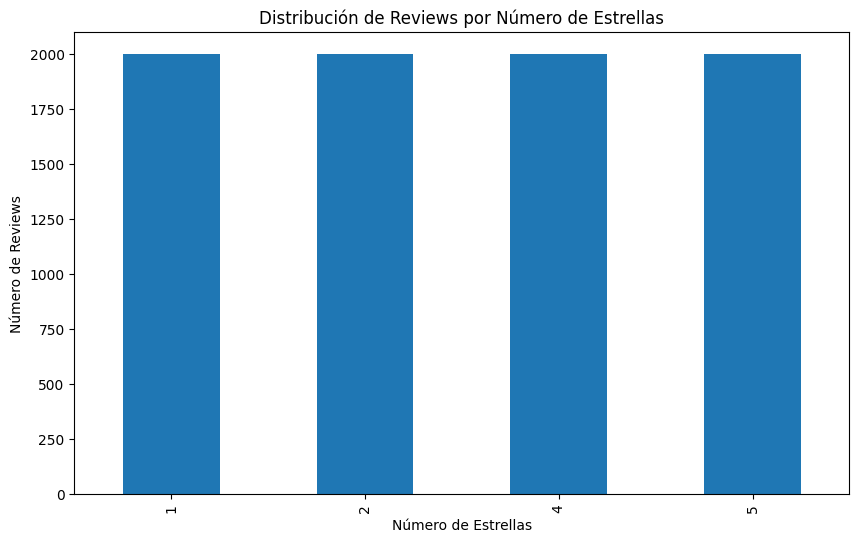

Número de reviews positivas: 4000
Número de reviews negativas: 4000
Unigrams más frecuentes:
br: 21234
book: 12440
read: 4036
like: 3695
story: 3428
just: 3357
good: 2339
really: 2267
books: 2118
34: 2063

Bigrams más frecuentes:
br br: 9137
br book: 572
year old: 378
read book: 356
book br: 349
main character: 242
ve read: 224
don know: 198
like book: 194
reading book: 185


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


#Cargamos el subset
df_subset = pd.read_csv('datos_extraidos.csv')

# Verificar las primeras filas del DataFrame
print(df_subset.head())

# Información general sobre el DataFrame
print(df_subset.info())

# Estadísticas descriptivas básicas
print(df_subset.describe())
# Contar el número total de reseñas en el subconjunto
print(f"Número total de reseñas: {len(df_subset)}")

# Verificar si hay valores nulos
print('Valores nulos')
print(df_subset.isnull().sum())

# 1. Cardinalidad del vocabulario
vectorizer = CountVectorizer()
vectorizer.fit(df_subset['text'])
vocab_cardinality = len(vectorizer.get_feature_names_out())
print(f'Cardinalidad del vocabulario: {vocab_cardinality}')

# 2. Distribución de reviews por número de estrellas
plt.figure(figsize=(10, 6))
df_subset['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Reviews por Número de Estrellas')
plt.xlabel('Número de Estrellas')
plt.ylabel('Número de Reviews')
plt.show()

# 3. Número de reviews positivas y negativas
positive_reviews = df_subset[df_subset['rating'] >= 4].shape[0]
negative_reviews = df_subset[df_subset['rating'] <= 2].shape[0]

print(f'Número de reviews positivas: {positive_reviews}')
print(f'Número de reviews negativas: {negative_reviews}')

# Unigrams más frecuentes
unigram_vectorizer = CountVectorizer(stop_words='english')
unigrams = unigram_vectorizer.fit_transform(df_subset['text'])
unigram_counts = unigrams.sum(axis=0).A1
unigram_freq = [(word, unigram_counts[i]) for word, i in unigram_vectorizer.vocabulary_.items()]
unigram_freq_sorted = sorted(unigram_freq, key=lambda x: x[1], reverse=True)

print("Unigrams más frecuentes:")
for unigram, count in unigram_freq_sorted[:10]:
    print(f'{unigram}: {count}')

# Bigrams más frecuentes
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigrams = bigram_vectorizer.fit_transform(df_subset['text'])
bigram_counts = bigrams.sum(axis=0).A1
bigram_freq = [(word, bigram_counts[i]) for word, i in bigram_vectorizer.vocabulary_.items()]
bigram_freq_sorted = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

print("\nBigrams más frecuentes:")
for bigram, count in bigram_freq_sorted[:10]:
    print(f'{bigram}: {count}')


La palabra "br" aparece con alta frecuencia, indicando que hay elementos HTML no limpiados en los datos.Entre los unigrams, términos como "book", "read", "like", "story" y "good" destacan, lo que sugiere una alta relevancia del tema central, reflejando opiniones sobre la experiencia de lectura. En cuanto a los bigrams, "br br" es el más común, seguido de combinaciones significativas como "year old" y "read book", que indican temas recurrentes en las reseñas. Esto sugiere que es necesario realizar una limpieza adicional de datos para mejorar el análisis

Con base en estos hallazgos, debemos proceder con un preprocesamiento exhaustivo del texto para limpiar los datos y preparar un conjunto adecuado para el modelado de análisis de sentimientos. Esto incluirá la eliminación de stopwords, la lematización y la tokenización, lo cual permitirá obtener representaciones más precisas del contenido textual.

## PREPROCESAMIENTO

In [10]:
#!pip install nltk

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Descargar recursos necesarios de NLTK
nltk.download('all')

In [9]:
def preprocess_text(text):
    """
    Función principal que realiza todo el preprocesamiento del texto.
    """
    text = remove_html(text)
    text = convert_to_lowercase(text)
    text = expand_contractions(text)  # Manejo de contracciones
    text = remove_special_characters(text)
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_words(tokens)
    processed_text = ' '.join(tokens)
    return processed_text

def remove_html(text):
    """Elimina etiquetas HTML y separa palabras concatenadas."""
    # Eliminar etiquetas HTML y reemplazar por espacio
    text = re.sub(r'<.*?>', ' ', text)
    # Reemplazar caracteres no alfabéticos por espacio
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Reemplazar múltiples espacios en blanco por uno solo
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def convert_to_lowercase(text):
    """Convierte el texto a minúsculas."""
    return text.lower()

def expand_contractions(text):
    """Expande contracciones comunes."""
    contractions_dict = {
        "don't": "do not",
        "can't": "cannot",
        "I've": "I have",
        "you're": "you are",
        "he's": "he is",
        "she's": "she is",
        "it's": "it is",
        "we're": "we are",
        "they're": "they are",
        "wasn't": "was not",
        "weren't": "were not",
        "isn't": "is not",
        "aren't": "are not",
        "i'm": "I am",
        "let's": "let us",
        "that's": "that is",

    }

    # Reemplazar contracciones en el texto
    for contraction, expanded in contractions_dict.items():
        text = re.sub(r'\b' + contraction + r'\b', expanded, text, flags=re.IGNORECASE)

    return text

def remove_special_characters(text):
    """Elimina caracteres especiales y números."""
    return re.sub(r'[^a-zA-Z\s]', '', text)

def tokenize_text(text):
    """Tokeniza el texto."""
    return word_tokenize(text)

def remove_stopwords(tokens):
    """Elimina stopwords."""
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def lemmatize_words(tokens):
    """Lematiza las palabras."""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

# Aplicar el preprocesamiento a la columna de texto
df_subset['processed_text'] = df_subset['text'].apply(preprocess_text)

# Verificar los resultados
print(df_subset[['text', 'processed_text']].head())

df_subset = df_subset[df_subset['processed_text'] != '']

                                                text  \
0  This is a very warped story about the author/B...   
1  Grandma bought this book at a brick and mortar...   
2  worst woods book i've read. and i have read th...   
3  Boring and flat.  Couldn't wait to finish it t...   
4  Don't waste your money on this deeply unhelpfu...   

                                      processed_text  
0  warped story author brenner sex dolphin yes do...  
1  grandma bought book brick mortar store feel li...  
2  worst wood book read read believe stuart wood ...  
3       boring flat wait finish start something else  
4  waste money deeply unhelpful book unless tryin...  


El preprocesamiento ha sido exitoso, resultando en una columna 'processed_text' que refleja una limpieza efectiva del contenido original. Las etiquetas HTML han sido eliminadas y el texto ha sido convertido a minúsculas, facilitando su análisis. Además, se han expandido las contracciones comunes, lo que mejora la comprensión. Se han eliminado las stopwords, permitiendo que el análisis se enfoque en términos más significativos. La lematización ha reducido palabras como "woods" a "wood", ayudando a agrupar términos relacionados. En general, el preprocesamiento proporciona una base sólida para el análisis de sentimiento y modelización, aunque se recomienda revisar la lista de stopwords y considerar ajustes adicionales para mejorar la calidad del texto procesado.

In [ ]:
# Guardar como CSV 
df_subset.to_csv('datos_procesados.csv', index=False)

## ENTRENAMIENTO - EVALUACION - REGISTRO DE METRICAS

In [2]:
import argparse
import subprocess
import time
import mlflow
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


df = pd.read_csv('datos_procesados.csv')
df['label'] = (df['rating'] >= 4).astype(int) 

X = df['processed_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

max_features=8000
vectorizer = TfidfVectorizer(max_features=max_features)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
    

mlflow_ui_process = subprocess.Popen(['mlflow', 'ui', '--port', '8888'])
print(mlflow_ui_process)
time.sleep(5)
mlflow.set_experiment('Analisis_Sentimientos')

max_iter = 1000
C_values = [0.1,1.0,5.0,10.0]   
for C in C_values:
    with mlflow.start_run(run_name=f"LogisticRegression_C_{C}_MaxIter_{max_iter}"):
        model = LogisticRegression(C=C, max_iter=max_iter, random_state=42)
        model.fit(X_train_vectorized, y_train)            

        # Calcular accuracy de entrenamiento y prueba
        train_accuracy = model.score(X_train_vectorized, y_train)
        test_accuracy = model.score(X_test_vectorized, y_test)

        # Evaluar el modelo
        y_pred = model.predict(X_test_vectorized)
        classification_rep_text = classification_report(y_test, y_pred)  # Generar el reporte en formato de texto
        conf_matrix = confusion_matrix(y_test, y_pred)
        
            
        # Logging de métricas y parámetros
        mlflow.log_param("C", C)
        mlflow.log_param("max_iter", max_iter)
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("test_accuracy", test_accuracy)

        # Guardar la matriz de confusión como artefacto
        mlflow.log_text(str(conf_matrix), "confusion_matrix.txt")
            
        # Guardar el reporte de clasificación como artefacto en formato de texto
        mlflow.log_text(classification_rep_text, "classification_report.txt")
            
        # Guardar el modelo
        mlflow.sklearn.log_model(model, "logistic_regression_model")
    
print("Se ha acabado el entrenamiento de los modelos correctamente")

<Popen: returncode: None args: ['mlflow', 'ui', '--port', '8888']>


2024/12/14 00:25:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/14 00:25:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/14 00:25:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/14 00:25:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Se ha acabado el entrenamiento de los modelos correctamente


En este ejemplo se muestra classification report en formato txt

![descripción de la imagen](1.png)

![descripción de la imagen](2.png)

![descripción de la imagen](3.png)

![descripción de la imagen](4.png)

### Generar .py de funciones y main con al menos dos argumentos de entrada.
    Se muestra el codigo en celdas independientes y se adjuntan los archivos  util.py  y  main.py

In [ ]:
%%writefile util.py

import argparse
import subprocess
import time
import mlflow
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

def argumentos():
    parser = argparse.ArgumentParser(description='__main__ de la aplicación con argumentos de entrada.')
    parser.add_argument('--nombre_job', type=str, help='Valor para el parámetro nombre_documento.')
    parser.add_argument('--max_features', type=int, default=8000, help='Número máximo de características para TfidfVectorizer.')
    parser.add_argument('--max_iter', type=int, default=1000, help='Número máximo de iteraciones para LogisticRegression.')
    parser.add_argument('--C_values', nargs='+', type=float, default=[0.1, 1.0, 10.0], help='Valores de C para LogisticRegression.')
    return parser.parse_args()

def load_dataset():
    df_subset = pd.read_csv('datos_procesados.csv')
    df_subset['label'] = (df_subset['rating'] >= 4).astype(int)
    return df_subset

def data_treatment(df):
    X = df['processed_text']
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
    return X_train, X_test, y_train, y_test

def vectorize_text(X_train, X_test, max_features):
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    return X_train_vectorized, X_test_vectorized, vectorizer

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)  # Generar el reporte en formato de texto
    conf_matrix = confusion_matrix(y_test, y_pred)
    return report, conf_matrix

def mlflow_tracking(nombre_job, X_train, X_test, y_train, y_test, max_iter, C_values):
    mlflow_ui_process = subprocess.Popen(['mlflow', 'ui', '--port', '8888'])
    print(mlflow_ui_process)
    time.sleep(5)
    mlflow.set_experiment(nombre_job)
    
    for C in C_values:
        with mlflow.start_run(run_name=f"LogisticRegression_C_{C}_MaxIter_{max_iter}"):
            model = LogisticRegression(C=C, max_iter=max_iter, random_state=42)
            model.fit(X_train, y_train)            

            # Calcular accuracy de entrenamiento y prueba
            train_accuracy = model.score(X_train, y_train)
            test_accuracy = model.score(X_test, y_test)

            # Evaluar el modelo
            classification_rep_text, conf_matrix = evaluate_model(model, X_test, y_test)
            
            # Logging de métricas y parámetros
            mlflow.log_param("C", C)
            mlflow.log_param("max_iter", max_iter)
            mlflow.log_metric("train_accuracy", train_accuracy)
            mlflow.log_metric("test_accuracy", test_accuracy)

            # Guardar la matriz de confusión como artefacto
            mlflow.log_text(str(conf_matrix), "confusion_matrix.txt")
            
            # Guardar el reporte de clasificación como artefacto en formato de texto
            mlflow.log_text(classification_rep_text, "classification_report.txt")
            
            # Guardar el modelo
            mlflow.sklearn.log_model(model, "logistic_regression_model")
    
    print("Se ha acabado el entrenamiento de los modelos correctamente")


In [ ]:
%%writefile main.py

from util import argumentos, load_dataset, data_treatment, vectorize_text, mlflow_tracking

def main():
    print("Ejecutamos el main")
    args_values = argumentos()
    df = load_dataset()
    X_train, X_test, y_train, y_test = data_treatment(df)
    X_train_vectorized, X_test_vectorized, vectorizer = vectorize_text(X_train, X_test, args_values.max_features)
    mlflow_tracking(args_values.nombre_job, X_train_vectorized, X_test_vectorized, y_train, y_test, args_values.max_iter, args_values.C_values)

if __name__ == "__main__":
    main()

En este ejemplo se muestran f1-score, prescision y recall en las métricas

![descripción de la imagen](5.png)

![descripción de la imagen](6.png)

![descripción de la imagen](7.png)

![descripción de la imagen](8.png)

Basándonos en estos resultados, podemos concluir lo siguiente:
1.	Rendimiento general:
•	Todos los modelos tienen un rendimiento relativamente bueno, con precisión de prueba (test_accuracy) entre 0.83 y 0.848.
•	El mejor rendimiento en el conjunto de prueba se obtiene con C=1.0, logrando una precisión de 0.848.
2.	Regularización y generalización:
•	A medida que C disminuye (de 10.0 a 0.1), la regularización aumenta.
•	Observamos que el modelo con C=1.0 logra el mejor equilibrio entre rendimiento en entrenamiento y prueba.
3.	Sobreajuste:
•	Hay evidencia de sobreajuste, especialmente en los modelos con C más alto.
•	Para C=10.0, la precisión de entrenamiento es 0.978, mientras que la de prueba es solo 0.835, indicando un sobreajuste significativo.
•	El sobreajuste disminuye a medida que C disminuye, con la brecha más pequeña entre train_accuracy y test_accuracy en C=0.1.
4.	Mejor modelo:
•	El modelo con C=1.0 parece ser el mejor, con la precisión de prueba más alta (0.848) y un buen equilibrio entre rendimiento en entrenamiento (0.925) y prueba.
5.	Consistencia de métricas:
•	Para cada modelo, las métricas de accuracy, f1-score, precision y recall son idénticas, lo que sugiere un rendimiento equilibrado en todas las clases.
6.	Matrices de confusión:
•	Las matrices de confusión muestran un rendimiento bastante equilibrado entre verdaderos positivos y verdaderos negativos.
•	El modelo con C=1.0 tiene la mejor matriz de confusión, con 674 y 681 predicciones correctas.

En resumen, el modelo con C=1.0 ofrece el mejor rendimiento general, con un buen equilibrio entre ajuste a los datos de entrenamiento y generalización a los datos de prueba. Sin embargo, todos los modelos muestran cierto grado de sobreajuste, lo que podría abordarse con técnicas adicionales de regularización o ajuste de hiperparámetros.


## Práctica parte FastAPI

### Para esta parte de la práctica teneis que generar un script con al menos 5 modulos app.get y dos de ellos tienen que ser pipelines de HF. 

### Parte de la practica se tendra que entregar en capturas de pantalla. Las capturas de pantalla a adjuntas son las siguientes. 

### 1. Captura de la pantalla docs con al menos 5 modulos.
     Se adjunta archivo FASTAPI

![descripción de la imagen](0.jpg)

### 2. Captura de cada una de los modulos con la respuesta dentro de docs.
     Se adjunta archivo PRUEBAS FASTAPI

![descripción de la imagen](1.jpg)

![descripción de la imagen](2.jpg)

![descripción de la imagen](3.jpg)

![descripción de la imagen](4.jpg)

![descripción de la imagen](5.jpg)

![descripción de la imagen](6.jpg)

![descripción de la imagen](7.jpg)

![descripción de la imagen](8.jpg)

![descripción de la imagen](9.jpg)

![descripción de la imagen](10.jpg)

### 3. Captura de cada uno de los modulos en la llamada https.
     Se ejecuta cada llamada en una celda independiente

### 4. Todo el codigo usado durante el proceso. Notebooks y scripts.
     Se muestra el codigo en celdas independientes y se adjunta archivo app_fastapi.py

In [ ]:
%%writefile app_fastapi.py
from fastapi import FastAPI, Query
from pydantic import BaseModel
from transformers import pipeline
import random

app = FastAPI()

# Cargar los pipelines de Hugging Face
text_classification_pipeline = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")
text_generation_pipeline = pipeline("text-generation", model="gpt2")

# Definir modelos de entrada
class TextRequest(BaseModel):
    text: str

class GenerateRequest(BaseModel):
    prompt: str

@app.get("/")
def read_root():
    """
    Endpoint de bienvenida.
    """
    return {"message": "Bienvenido a pruebas API"}

@app.post("/classify")
def classify_text(request: TextRequest):
    """
    Clasifica el texto proporcionado usando un modelo de Hugging Face.
    """
    result = text_classification_pipeline(request.text)
    return result

@app.post("/generate")
def generate_text(request: GenerateRequest):
    """
    Genera texto basado en el prompt proporcionado usando un modelo de Hugging Face.
    """
    result = text_generation_pipeline(request.prompt, max_length=50)
    return result

@app.get("/random_number")
def get_random_number():
    """
    Genera un número aleatorio entre 1 y 100.
    """
    return {"random_number": random.randint(1, 100)}

@app.get("/multiply")
def multiply(a: float = Query(..., description="First number to multiply"),
             b: float = Query(..., description="Second number to multiply")):
    """
    Multiplica dos números y devuelve el resultado.
    """
    result = a * b
    return {"result": result, "operation": f"{a} * {b} = {result}"}

@app.get("/fibonacci")
def fibonacci(n: int = Query(..., description="Number of Fibonacci sequence elements to generate", ge=1, le=100)):
    """
    Genera una secuencia de Fibonacci con n elementos.
    """
    fib = [0, 1]
    while len(fib) < n:
        fib.append(fib[-1] + fib[-2])
    return {"fibonacci_sequence": fib[:n]}

In [1]:
import requests

base_url = "http://127.0.0.1:8080"  

In [11]:
# Endpoint de clasificación
text_to_classify = {"text": "This is a great product!"}
response = requests.post(f"{base_url}/classify", json=text_to_classify)
print("Clasificación:", response.json())

Clasificación: [{'label': 'POSITIVE', 'score': 0.9998756647109985}]


In [3]:
# Endpoint de generación de texto
prompt = {"prompt": "Once upon a time"}
response = requests.post(f"{base_url}/generate", json=prompt)
print("Generación de texto:", response.json())

Generación de texto: [{'generated_text': 'Once upon a time in the early 21st century men had a sense of belonging and a sense of what might go wrong. At some point, we must have realized that there was no substitute for a healthy sense of self-worth. By the time'}]


In [4]:
# Endpoint de número aleatorio
response = requests.get(f"{base_url}/random_number")
print("Número aleatorio:", response.json())

Número aleatorio: {'random_number': 48}


In [5]:
# Endpoint de multiplicación
response = requests.get(f"{base_url}/multiply?a=5&b=3")
print("Multiplicación:", response.json())

Multiplicación: {'result': 15.0, 'operation': '5.0 * 3.0 = 15.0'}


In [6]:
# Endpoint de Fibonacci
response = requests.get(f"{base_url}/fibonacci?n=10")
print("Fibonacci:", response.json())

Fibonacci: {'fibonacci_sequence': [0, 1, 1, 2, 3, 5, 8, 13, 21, 34]}
